In [1]:
import os
import random
import math
import numpy as np
import json
import optuna
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Tuple, Optional

import pathlib
import sys
from glob import glob

BASE_DIR = str(pathlib.Path(os.getcwd()).parent)
sys.path.append(str(BASE_DIR))


In [2]:
BASE_DIR

'/Users/mori/dev/Othello-Web-app-with-RL/rl_agent'

In [3]:
MODEL_SAVE_DIR = os.path.join(BASE_DIR, "models", "v1")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

SEED = 42

In [4]:
EMPTY, BLACK, WHITE = 0, 1, -1
DIRECTIONS = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]

In [5]:
def opponent(c):
    """現在のプレイヤーの相手を返す"""
    return -c

class Othello:
    def __init__(self):
        self.board = [[EMPTY for _ in range(8)] for _ in range(8)]
        self.board[3][3] = self.board[4][4] = WHITE
        self.board[3][4] = self.board[4][3] = BLACK
        self.player = BLACK

    def clone(self):
        """盤面をコピーして新しいインスタンスを返す"""
        g = Othello()
        g.board = [row[:] for row in self.board]
        g.player = self.player
        return g

    def inside(self, r, c):
        """
        盤面の範囲内かを返す
        Args:
            r (int): 行
            c (int): 列
        Returns:
            bool: 盤面の範囲内か
        """
        return 0 <= r < 8 and 0 <= c < 8

    def legal_moves(self, player=None) -> List[Tuple[int, int]]:
        """
        合法手を返す
        Args:
            player (int, optional): プレイヤーの色.指定しない場合は現在のプレイヤーを返す
        Returns:
            List[Tuple[int, int]]: 合法手のリスト
        """
        if player is None:
            player = self.player
        moves = []
        for r in range(8):
            for c in range(8):
                if self.board[r][c] != EMPTY:  # 空白でない場合は合法手ではない
                    continue
                if self._would_flip(r, c, player):  # 石をひっくり返せる場合は合法手
                    moves.append((r, c))
        return moves

    def _would_flip(self, r, c, player) -> bool:
        """
        石をひっくり返せるかを返す
        Args:
            r (int): 行
            c (int): 列
            player (int): プレイヤーの色
        Returns:
            bool: 石をひっくり返せるか
        """
        if self.board[r][c] != EMPTY:  # 空白でない場合は石をひっくり返せない
            return False
        for dr, dc in DIRECTIONS:
            rr, cc = r + dr, c + dc
            seen_opp = False  # 相手の石を一度見たか
            while self.inside(rr, cc) and self.board[rr][cc] == opponent(player):  # 盤面の範囲内か & 相手の石が置かれている場所か
                seen_opp = True
                rr += dr; cc += dc
            if seen_opp and self.inside(rr, cc) and self.board[rr][cc] == player:  # 相手の石を一度見たか & 盤面の範囲内か & 自分の石をみたか
                return True
        return False

    def play(self, r, c, player=None):
        """
        石を置く & 石をひっくり返す
        Args:
            r (int): 行
            c (int): 列
            player (int, optional): プレイヤーの色.指定しない場合は現在のプレイヤーを返す
        """
        if player is None:
            player = self.player
        assert self.board[r][c] == EMPTY  # 空白でない場合は石を置くことができない
        flipped = []
        for dr, dc in DIRECTIONS:
            line = []
            rr, cc = r + dr, c + dc
            while self.inside(rr,cc) and self.board[rr][cc] == opponent(player):  # 盤面の範囲内か & 相手の石が置かれている場所か
                line.append((rr,cc))  # 石をひっくり返す場所を追加
                rr += dr; cc += dc
            if line and self.inside(rr,cc) and self.board[rr][cc] == player:  # 石をひっくり返す場所が存在 & 盤面の範囲内か & 自分の石をみたか
                flipped.extend(line)  # 石をひっくり返す場所を追加
        if not flipped:  # 石をひっくり返す場所が存在しない場合は不正な手
            raise ValueError("Illegal move")
        self.board[r][c] = player
        for rr,cc in flipped:  # 石をひっくり返す
            self.board[rr][cc] = player
        self.player = opponent(player)
        # 現在のプレイヤーが合法手がない場合は相手の番
        if not self.legal_moves(self.player):
            self.player = opponent(self.player)

    def terminal(self) -> bool:
        if self.legal_moves(BLACK): return False
        if self.legal_moves(WHITE): return False
        return True

    def score(self) -> int:
        """
        黒が+1, 白が-1としてスコアを計算
        Returns:
            int: スコア
        """
        s = 0
        for r in range(8):
            for c in range(8):
                s += self.board[r][c]
        return s

    def winner(self) -> int:
        s = self.score()
        return BLACK if s > 0 else WHITE if s < 0 else 0

    def play_and_return_flipped(self, r, c, player):
        flipped = []
        self.board[r][c] = player
        for dr, dc in DIRS:
            rr, cc = r + dr, c + dc
            temp = []
            while 0 <= rr < 8 and 0 <= cc < 8 and self.board[rr][cc] == -player:
                temp.append((rr, cc))
                rr += dr
                cc += dc
            if 0 <= rr < 8 and 0 <= cc < 8 and self.board[rr][cc] == player:
                for fr, fc in temp:
                    self.board[fr][fc] = player
                flipped.extend(temp)
        self.player = -player
        return flipped

    def undo_move(self, r, c, player, flipped):
        """ play_and_return_flipped で行った着手を元に戻す """
        self.board[r][c] = 0
        for fr, fc in flipped:
            self.board[fr][fc] = -player
        self.player = player

In [6]:
CORNER_CELLS = [(0, 0), (0, 7), (7, 0), (7, 7)]
XCELLS = [  # コーナー隣接(危険)
    (0,1),(1,0),(1,1),
    (0,6),(1,6),(1,7),
    (6,0),(6,1),(7,1),
    (6,6),(6,7),(7,6)
]
EDGE_CELLS = tuple(
    [(0,c) for c in range(2, 6)] + [(7,c) for c in range(2, 6)] +
    [(r,0) for r in range(2, 6)] + [(r,7) for r in range(2, 6)]
)  # エッジ（コーナー・コーナー隣接除く）

# opponent選択で毎回作らない
CORNER_SET = frozenset(CORNER_CELLS)
X_SET = frozenset(XCELLS)
EDGE_SET = frozenset(EDGE_CELLS)

# 正規化の逆数（除算より速い）
INV_64 = 1.0 / 64.0
INV_20 = 1.0 / 20.0
INV_4  = 1.0 / 4.0
INV_12 = 1.0 / 12.0
INV_16 = 1.0 / 16.0

def features(game: Othello, player: int):
    """
    特徴量を返す
    Args:
        game: Othello
        player: int
    Returns:
        list: 特徴量
    """
    b = game.board
    f_bias = 1.0

    # 石の数（率）
    my_disc = 0
    opp_disc = 0
    for r in range(8):
        br = b[r]  # 行のローカル参照でルックアップ削減
        for c in range(8):
            if br[c] == player:
                my_disc += 1
            elif br[c] == -player:
                opp_disc += 1
    f_parity = (my_disc - opp_disc) * INV_64  # 石差

    # モビリティ（合法手数）
    # legal_movesを2回呼ぶのは同じだが、lenだけ使うので即lenに
    lm = game.legal_moves
    my_moves = len(lm(player))
    opp_moves = len(lm(-player))
    f_mobility = (my_moves - opp_moves) * INV_20

    # 角/X/辺：両者を同時に数えて差分に（各集合につき1パス）
    def diff_count(cells):
        md = od = 0
        for r, c in cells:
            v = b[r][c]
            if v == player:
                md += 1
            elif v == -player:
                od += 1
        return md - od
    f_corner = diff_count(CORNER_CELLS) * INV_4  # 角の占有率
    f_x = - (diff_count(XCELLS) * INV_12)        # Xマスの占有率(ペナルティ)
    f_edge = diff_count(EDGE_CELLS) * INV_16     # 辺の占有率

    # タプルで返す（不変 & わずかに軽量）
    return (f_bias, f_parity, f_mobility, f_corner, f_x, f_edge)

class LinearValue:
    """
    線形価値関数
    """
    __slots__ = ('w', )  # 小さな省メモリ＋属性アクセス高速化
    def __init__(self, n_feat):
        self.w = [0.0]*n_feat

    def value(self, phi):
        """
        特徴量の値を返す
        Args:
            phi: 特徴量
        Returns:
            float: 値
        """
        # zipより手書きの方が関数呼び出しが減って速いことが多い
        w = self.w
        s = 0.0
        for i in range(len(w)):
            s += w[i] * phi[i]
        return s

    def update(self, phi, target, alpha):
        """
        更新
        Args:
            phi: 特徴量
            target: 目標値
            alpha: 学習率
        """
        v = self.value(phi)  # 現在の価値
        delta = target - v  # 目標値と現在の価値の差
        w = self.w
        a_delta = alpha * delta
        for i in range(len(w)):  # 重みを更新(n_feat分)
            w[i] += a_delta * phi[i]  # 重みを更新
        return delta

    def clone(self):
        nv = LinearValue(len(self.w))
        nv.w = self.w[:]   # コピー
        return nv

def choose_move_epsilon_greedy(game: Othello, player: int, V: LinearValue, eps=0.1, rng=None):
    """
    ε-greedyで行動を選択
    Args:
        game: Othello
        player: int
        V: LinearValue（線形価値関数）
        eps: float
    Returns:
        tuple: 選択した手
    """
    moves = game.legal_moves(player)  # 合法手
    if not moves:
        return None
    # eps未満の確率でランダム選択
    if rng is None:
        rng = random
    if rng.random() < eps:
        return rng.choice(moves)
    # afterstateの価値で貪欲選択
    best_v = -1e9  # 初期値をごく小さい値に設定
    best_m = moves[0]
    for m in moves:
        g2 = game.clone()
        g2.play(m[0], m[1], player)
        phi = features(g2, player)
        v = V.value(phi)
        if v > best_v:
            best_v = v
            best_m = m
    return best_m

def choose_move_random(game: Othello, player: int, rng=None):
    moves = game.legal_moves(player)
    if not moves:
        return None
    if rng is None:
        rng = random
    return rng.choice(moves)

def choose_move_heuristic(game: Othello, player: int, rng=None):
    corners = {(0,0),(0,7),(7,0),(7,7)}
    xset = set(XCELLS)
    edges = set(EDGE_CELLS)

    moves = game.legal_moves(player)
    if not moves:
        return None

    # 1) 角は必ず取る。複数ある場合は V で同値解消（なければランダム）
    corner_moves = [m for m in moves if m in corners]
    if corner_moves:
        if rng is None:
            rng = random
        return rng.choice(corner_moves)

    # X は極力避ける
    pool = [m for m in moves if m not in xset] or moves

    # 辺を優先
    edge_pool = [m for m in pool if m in edges] or pool

    if rng is None:
        rng = random
    return rng.choice(edge_pool)

def evaluate_position(game: Othello, player: int, V: LinearValue):
    phi = features(game, player)
    return V.value(phi)

from collections import OrderedDict

EXACT, LOWERBOUND, UPPERBOUND = 0, 1, 2

# Othello の 8 方向ベクトル（行・列の変化量）
DIRS = [
    (-1, -1), (-1, 0), (-1, 1),
    ( 0, -1),          ( 0, 1),
    ( 1, -1), ( 1, 0), ( 1, 1),
]

class TranspositionTable:
    def __init__(self, capacity=200_000):
        self.cap = capacity
        self.d = OrderedDict()

    def _prune(self):
        while len(self.d) > self.cap:
            self.d.popitem(last=False)

    def get(self, key):
        e = self.d.get(key)
        if e is not None:
            # LRU 更新
            self.d.move_to_end(key)
        return e

    def put(self, key, entry):
        self.d[key] = entry
        self.d.move_to_end(key)
        self._prune()

def board_key(game: Othello):
    # 盤面(タプル化) + 手番をキーに
    return (game.player, tuple(tuple(row) for row in game.board))

import random
from collections import OrderedDict

# Zobristハッシュ用の乱数表
ZOBRIST = [[[random.getrandbits(64) for _ in range(3)] for _ in range(8)] for _ in range(8)]

def zobrist_hash(game):
    h = 0
    for r in range(8):
        for c in range(8):
            v = game.board[r][c]
            idx = 0 if v == 0 else (1 if v == 1 else 2)
            h ^= ZOBRIST[r][c][idx]
    return h

class TranspositionTable:
    def __init__(self, capacity=200_000):
        self.cap = capacity
        self.d = OrderedDict()

    def _prune(self):
        while len(self.d) > self.cap:
            self.d.popitem(last=False)

    def get(self, key):
        e = self.d.get(key)
        if e is not None:
            self.d.move_to_end(key)
        return e

    def put(self, key, entry):
        self.d[key] = entry
        self.d.move_to_end(key)
        self._prune()

EXACT, LOWERBOUND, UPPERBOUND = 0, 1, 2

def minimax(game, player, V, depth, alpha=-1e9, beta=1e9, tt=None, hash_val=None):
    alpha0, beta0 = alpha, beta

    if hash_val is None:
        hash_val = zobrist_hash(game)

    # TT参照
    if tt is not None:
        ent = tt.get((hash_val, game.player, depth))
        if ent is not None:
            ent_depth, ent_val, ent_move, ent_flag = ent
            if ent_depth >= depth:
                if ent_flag == EXACT:
                    return ent_val, ent_move
                if ent_flag == LOWERBOUND and ent_val >= beta:
                    return ent_val, ent_move
                if ent_flag == UPPERBOUND and ent_val <= alpha:
                    return ent_val, ent_move

    if depth == 0 or game.terminal():
        return evaluate_position(game, player, V), None

    moves = game.legal_moves(game.player)
    if not moves:
        game.player = -game.player
        val, _ = minimax(game, player, V, depth-1, alpha, beta, tt, hash_val)
        game.player = -game.player
        if tt is not None:
            tt.put((hash_val, game.player, depth), (depth, val, None, EXACT))
        return val, None

    moves.sort(
        key=lambda m: evaluate_position_after_move(game, m, player, V),
        reverse=(game.player == player)
    )

    best_move = moves[0]
    if game.player == player:  # maximize
        val = -1e9
        for m in moves:
            flipped = game.play_and_return_flipped(m[0], m[1], game.player)
            sc, _ = minimax(game, player, V, depth-1, alpha, beta, tt, hash_val)
            game.undo_move(m[0], m[1], -game.player, flipped)
            if sc > val:
                val, best_move = sc, m
            alpha = max(alpha, val)
            if beta <= alpha:
                break
        flag = EXACT if alpha0 < val < beta0 else (LOWERBOUND if val >= beta0 else UPPERBOUND)
    else:  # minimize
        val = 1e9
        for m in moves:
            flipped = game.play_and_return_flipped(m[0], m[1], game.player)
            sc, _ = minimax(game, player, V, depth-1, alpha, beta, tt, hash_val)
            game.undo_move(m[0], m[1], -game.player, flipped)
            if sc < val:
                val, best_move = sc, m
            beta = min(beta, val)
            if beta <= alpha:
                break
        flag = EXACT if alpha0 < val < beta0 else (UPPERBOUND if val <= alpha0 else LOWERBOUND)

    if tt is not None:
        tt.put((hash_val, game.player, depth), (depth, val, best_move, flag))

    return val, best_move

def play_with_hash(game, move, hash_val):
    """ 石を置き、Zobristハッシュを更新。返り値は(裏返した石の位置リスト, 更新後ハッシュ) """
    r, c = move
    player = game.player
    flipped = game.play_and_return_flipped(r, c, player)  # 既存Othelloクラスに追加する必要あり
    hash_val ^= ZOBRIST[r][c][0 if player == 0 else (1 if player == 1 else 2)]
    for fr, fc in flipped:
        v = game.board[fr][fc]
        hash_val ^= ZOBRIST[fr][fc][0 if -player == 0 else (1 if -player == 1 else 2)]
        hash_val ^= ZOBRIST[fr][fc][0 if player == 0 else (1 if player == 1 else 2)]
    game.player = -player
    return flipped, hash_val

def undo_with_hash(game, move, flipped, hash_val):
    """ 石を元に戻し、Zobristハッシュも戻す """
    r, c = move
    player = -game.player
    game.board[r][c] = 0
    for fr, fc in flipped:
        game.board[fr][fc] = -player
    game.player = player

def choose_move_search(game, player, V, depth=2, tt=None, rng=None):
    if tt is None:
        tt = TranspositionTable(capacity=300_000)
    _, m = minimax(game, player, V, depth, tt=tt)
    return m or choose_move_random(game, player, rng=rng)

def evaluate_position_after_move(game, move, player, V):
    # 高速版のみ残す
    r, c = move
    flipped = game.play_and_return_flipped(r, c, game.player)
    val = evaluate_position(game, player, V)
    game.undo_move(r, c, -game.player, flipped)
    return val

def choose_move(game: Othello, player: int, opp_type: str="heuristic", V: LinearValue=None, eps=0.05, rng=None):
    """
    相手用の手選択
    Args:
        game: Othello
        player: int
        opp_type: str (random, epsilon-greedy, heuristic, greedy)
        V: LinearValue
        eps: float
    Returns:
        tuple: 選択した手
    """
    moves = game.legal_moves(player)
    if not moves:
        return None

    elif opp_type == "random":         return choose_move_random(game, player, rng=rng)
    elif opp_type == "heuristic":      return choose_move_heuristic(game, player, rng=rng)
    elif opp_type == "epsilon-greedy": return choose_move_epsilon_greedy(game, player, V, eps=eps, rng=rng)
    elif opp_type == "greedy":         return choose_move_epsilon_greedy(game, player, V, eps=0.0, rng=rng)

def sample_train_opponent(t, T, rng, Vs):
    """
    学習時の相手選択（Vs＋自己対戦＋検索を重め）
    戻り値: dict {opp_type, opp_V}
    """
    k = t / T  # 進捗(0→1)

    # 開始/終了時の目標配分（合計=1.0）
    start = {'rand': 0.08, 'heur': 0.12, 'self': 0.30, 'vs_greedy': 0.30, 'vs_search': 0.20}
    end   = {'rand': 0.05, 'heur': 0.08, 'self': 0.30, 'vs_greedy': 0.27, 'vs_search': 0.30}

    def lerp(a, b): return a*(1-k) + b*k

    w_rand      = lerp(start['rand'],      end['rand'])
    w_heur      = lerp(start['heur'],      end['heur'])
    w_self      = lerp(start['self'],      end['self'])
    w_vs_greedy = lerp(start['vs_greedy'], end['vs_greedy'])
    w_vs_search = lerp(start['vs_search'], end['vs_search'])

    if not Vs:
        w_self += (w_vs_greedy + w_vs_search)
        w_vs_greedy = w_vs_search = 0.0

    x = rng.random()
    if x < w_rand:       return {"opp_type": "random", "opp_V": None}
    x -= w_rand
    if x < w_heur:       return {"opp_type": "heuristic", "opp_V": None}
    x -= w_heur
    if x < w_self:       return {"opp_type": "epsilon-greedy", "opp_V": None}
    x -= w_self
    if x < w_vs_greedy:  return {"opp_type": "greedy", "opp_V": rng.choice(Vs)}
    # 検索（Vsから選んでdepth=2で対戦）
    return {"opp_type": "search", "opp_V": rng.choice(Vs)}

def play_one_game(
    V: LinearValue, alpha=0.01, eps=0.1, learn=True,
    opp_type="random", opp_color=WHITE, opp_eps=0.05, opp_V: LinearValue=None,
    rng=None,
    opp_search_depth: int = 2,   # ← 追加：相手の探索深さ
):
    g = Othello()
    histories = []
    agent_color = opponent(opp_color)

    if opp_type == "search":
        if 'tt' not in locals():
            tt = TranspositionTable(capacity=300_000)

    while not g.terminal():
        p = g.player

        if p == opp_color:  # 相手番
            if opp_type == "search":
                use_V = opp_V if opp_V is not None else V
                m = choose_move_search(g, p, use_V, opp_search_depth, tt=tt)
            elif opp_type in ("epsilon-greedy", "greedy"):
                use_V = opp_V if opp_V is not None else V
                use_eps = opp_eps if opp_type == "epsilon-greedy" else 0.0
                m = choose_move(g, p, opp_type="epsilon-greedy", V=use_V, eps=use_eps, rng=rng)
            else:
                m = choose_move(g, p, opp_type=opp_type, rng=rng)
        else:               # 自分番（学習は従来通りε-greedy）
            m = choose_move(g, p, opp_type="epsilon-greedy", V=V, eps=eps, rng=rng)

        if m is None:
            g.player = opponent(g.player)
            continue

        g2 = g.clone()
        g2.play(m[0], m[1], p)
        if learn and p == agent_color:
            phi_after = features(g2, p)
            histories.append((phi_after, p))
        g.play(m[0], m[1], p)

    w = g.winner()
    reward_black = 1.0 if w == BLACK else -1.0 if w == WHITE else 0.0

    if learn:
        for phi, p in histories:
            target = reward_black if p == BLACK else -reward_black
            V.update(phi, target, alpha)

    return w

def train(
    trial,                     # ★ optuna.Trial を先頭引数に
    stop_patience=5,          # 改善がない評価が続いたら prune
    num_games=5000, alpha=0.01, eps=0.2, Vs=None,
    eval_interval=250, num_games_eval=100, seed=SEED
):
    Vs = Vs or []

    rng_train = random.Random(seed)
    rng_eval  = random.Random(None if seed is None else seed + 10_000)

    V = LinearValue(n_feat=len(features(Othello(), BLACK)))
    train_history = []
    initial_eps = eps

    # --- 評価相手プール（あなたの現状コードを踏襲） ---
    eval_weights = {"random": 1, "heuristic": 1, "V_greedy": 2, "V_search": 5}
    eval_pool = []
    eval_pool += [{"name":"random","opp_type":"random","opp_color":WHITE,"opp_V":None}]*eval_weights["random"]
    eval_pool += [{"name":"heuristic","opp_type":"heuristic","opp_color":WHITE,"opp_V":None}]*eval_weights["heuristic"]
    for i_v, v in enumerate(Vs, 1):
        eval_pool += [{"name":f"V{i_v}_g","opp_type":"greedy","opp_color":WHITE,"opp_V":v}]*eval_weights["V_greedy"]
        eval_pool += [{"name":f"V{i_v}_s","opp_type":"search","opp_color":WHITE,"opp_V":v}]*eval_weights["V_search"]
    if not eval_pool:
        eval_pool = [
            {"name":"random","opp_type":"random","opp_color":WHITE,"opp_V":None},
            {"name":"heuristic","opp_type":"heuristic","opp_color":WHITE,"opp_V":None},
        ]

    best_V = V.clone()
    best_win_rate = -1.0

    for i in range(1, num_games+1):
        # ε を線形に減衰
        current_eps = initial_eps * (1 - i / num_games)

        # 学習対戦
        opp_cfg = sample_train_opponent(i, num_games, rng_train, Vs)
        _ = play_one_game(
            V, alpha=alpha, eps=current_eps, learn=True,
            opp_type=opp_cfg["opp_type"], opp_color=WHITE, opp_eps=0.05,
            opp_V=opp_cfg["opp_V"], rng=rng_train
        )

        # 定期評価
        if i % eval_interval == 0:
            results = {"me": 0, "opp": 0, "draw": 0}
            for j in range(num_games_eval):
                et = eval_pool[j % len(eval_pool)]
                current_opp_color = WHITE if (j % 2 == 0) else BLACK
                w = play_one_game(
                    V, alpha=0.0, eps=0.0, learn=False,
                    opp_type=et["opp_type"], opp_color=current_opp_color,
                    opp_eps=0.0, opp_V=et["opp_V"], rng=rng_eval,
                    opp_search_depth=3
                )
                if w == 0: results["draw"] += 1
                elif w == current_opp_color: results["opp"] += 1
                else: results["me"] += 1

            win_rate  = results["me"] / num_games_eval
            lose_rate = results["opp"] / num_games_eval
            draw_rate = results["draw"] / num_games_eval
            train_history.append({
                "game": i,
                "win_rate": win_rate,
                "lose_rate": lose_rate,
                "draw_rate": draw_rate,
            })
            print(f"Game {i}: Win {win_rate:.2f} Lose {lose_rate:.2f} Draw {draw_rate:.2f}")

            # --- ベスト更新 & 早期終了カウンタ ---
            if win_rate > best_win_rate:
                best_win_rate = win_rate
                best_V = V.clone()

    return best_V, best_win_rate, train_history

def plot_train_history(train_history):
    """
    学習履歴を可視化
    Args:
        train_history: list（学習履歴）
    Returns:
        None
    """
    xs = [h['game'] for h in train_history]
    b = [h["win_rate"] for h in train_history]
    w = [h["lose_rate"] for h in train_history]
    d = [h["draw_rate"] for h in train_history]
    plt.figure(figsize=(7, 4))
    plt.plot(xs, b, label="Win rate")
    plt.plot(xs, w, label="Lose rate")
    plt.plot(xs, d, label="Draw rate")
    plt.xlabel("Games")
    plt.ylabel("Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
# optunaでのパラメータチューニング
db_dir = os.path.join(BASE_DIR, "dbs", "v1")
os.makedirs(db_dir, exist_ok=True)

db_path = os.path.join(db_dir, "5.sqlite")

# 対戦に用いるエージェントの価値関数
Vs = []
v_json_paths = glob(os.path.join(MODEL_SAVE_DIR, "*"))
for path in v_json_paths:
    with open(path, "r") as f:
        V = LinearValue(n_feat=len(features(Othello(), BLACK)))
        V.w = json.load(f)
    Vs.append(V)
print(f"len(Vs): {len(Vs)}")

def objective(trial: optuna.Trial):
    alpha = trial.suggest_float("alpha", 1e-3, 1e-2, log=True)
    eps   = trial.suggest_float("eps",   0.3, 0.5, log=True)
    num_games = trial.suggest_int("num_games", 500, 10000, step=250)

    print(f"\nTrial {trial.number}: alpha={alpha}, eps={eps}, num_games={num_games}")

    trial_seed = 42 + trial.number * 9973
    V, best_win_rate, train_history = train(
        trial=trial,
        stop_patience=5,
        num_games=num_games,
        alpha=alpha,
        eps=eps,
        Vs=Vs,
        seed=trial_seed
    )
    # 直近評価の勝率を目的関数値に
    return best_win_rate

sampler = optuna.samplers.TPESampler(seed=42, n_startup_trials=8)
study = optuna.create_study(
    study_name="a",
    storage=f"sqlite:///{db_path}",
    sampler=sampler,
    load_if_exists=True,
    direction="maximize"
)
study.optimize(objective, n_trials=30)

best_params = study.best_params
print("best_params:", best_params)

len(Vs): 3


[I 2025-08-11 20:11:50,041] A new study created in RDB with name: a



Trial 0: alpha=0.0023688639503640775, eps=0.48756894362117126, num_games=7500
Game 250: Win 0.31 Lose 0.69 Draw 0.00
Game 500: Win 0.51 Lose 0.49 Draw 0.00
Game 750: Win 0.47 Lose 0.52 Draw 0.01
Game 1000: Win 0.50 Lose 0.50 Draw 0.00
Game 1250: Win 0.49 Lose 0.51 Draw 0.00
Game 1500: Win 0.52 Lose 0.48 Draw 0.00
Game 1750: Win 0.50 Lose 0.50 Draw 0.00
Game 2000: Win 0.50 Lose 0.50 Draw 0.00
Game 2250: Win 0.47 Lose 0.53 Draw 0.00
Game 2500: Win 0.60 Lose 0.39 Draw 0.01
Game 2750: Win 0.31 Lose 0.67 Draw 0.02
Game 3000: Win 0.49 Lose 0.50 Draw 0.01
Game 3250: Win 0.49 Lose 0.51 Draw 0.00
Game 3500: Win 0.32 Lose 0.67 Draw 0.01
Game 3750: Win 0.65 Lose 0.35 Draw 0.00
Game 4000: Win 0.46 Lose 0.54 Draw 0.00
Game 4250: Win 0.33 Lose 0.66 Draw 0.01
Game 4500: Win 0.49 Lose 0.51 Draw 0.00
Game 4750: Win 0.65 Lose 0.35 Draw 0.00
Game 5000: Win 0.32 Lose 0.68 Draw 0.00
Game 5250: Win 0.37 Lose 0.49 Draw 0.14
Game 5500: Win 0.38 Lose 0.62 Draw 0.00
Game 5750: Win 0.51 Lose 0.49 Draw 0.00
Game

[I 2025-08-11 20:24:25,240] Trial 0 finished with value: 0.79 and parameters: {'alpha': 0.0023688639503640775, 'eps': 0.48756894362117126, 'num_games': 7500}. Best is trial 0 with value: 0.79.


Game 7500: Win 0.34 Lose 0.66 Draw 0.00

Trial 1: alpha=0.003968793330444372, eps=0.32488809305694755, num_games=2000
Game 250: Win 0.34 Lose 0.65 Draw 0.01
Game 500: Win 0.51 Lose 0.49 Draw 0.00
Game 750: Win 0.32 Lose 0.68 Draw 0.00
Game 1000: Win 0.48 Lose 0.52 Draw 0.00
Game 1250: Win 0.50 Lose 0.50 Draw 0.00
Game 1500: Win 0.48 Lose 0.52 Draw 0.00
Game 1750: Win 0.52 Lose 0.48 Draw 0.00


[I 2025-08-11 20:27:49,541] Trial 1 finished with value: 0.52 and parameters: {'alpha': 0.003968793330444372, 'eps': 0.32488809305694755, 'num_games': 2000}. Best is trial 0 with value: 0.79.


Game 2000: Win 0.48 Lose 0.34 Draw 0.18

Trial 2: alpha=0.001143098387631322, eps=0.4669617948657118, num_games=6250
Game 250: Win 0.50 Lose 0.50 Draw 0.00
Game 500: Win 0.49 Lose 0.51 Draw 0.00
Game 750: Win 0.48 Lose 0.35 Draw 0.17
Game 1000: Win 0.48 Lose 0.51 Draw 0.01
Game 1250: Win 0.34 Lose 0.66 Draw 0.00
Game 1500: Win 0.32 Lose 0.68 Draw 0.00
Game 1750: Win 0.16 Lose 0.84 Draw 0.00
Game 2000: Win 0.18 Lose 0.82 Draw 0.00
Game 2250: Win 0.21 Lose 0.78 Draw 0.01
Game 2500: Win 0.48 Lose 0.51 Draw 0.01
Game 2750: Win 0.48 Lose 0.51 Draw 0.01
Game 3000: Win 0.65 Lose 0.35 Draw 0.00
Game 3250: Win 0.32 Lose 0.67 Draw 0.01
Game 3500: Win 0.30 Lose 0.69 Draw 0.01
Game 3750: Win 0.31 Lose 0.67 Draw 0.02
Game 4000: Win 0.46 Lose 0.54 Draw 0.00
Game 4250: Win 0.33 Lose 0.67 Draw 0.00
Game 4500: Win 0.48 Lose 0.51 Draw 0.01
Game 4750: Win 0.32 Lose 0.67 Draw 0.01
Game 5000: Win 0.18 Lose 0.82 Draw 0.00
Game 5250: Win 0.33 Lose 0.66 Draw 0.01
Game 5500: Win 0.19 Lose 0.80 Draw 0.01
Game 5

[I 2025-08-11 20:39:43,019] Trial 2 finished with value: 0.65 and parameters: {'alpha': 0.001143098387631322, 'eps': 0.4669617948657118, 'num_games': 6250}. Best is trial 0 with value: 0.79.


Game 6250: Win 0.31 Lose 0.69 Draw 0.00

Trial 3: alpha=0.005105903209394756, eps=0.30317116948444556, num_games=9750
Game 250: Win 0.03 Lose 0.96 Draw 0.01
Game 500: Win 0.47 Lose 0.52 Draw 0.01
Game 750: Win 0.35 Lose 0.65 Draw 0.00
Game 1000: Win 0.34 Lose 0.66 Draw 0.00
Game 1250: Win 0.34 Lose 0.65 Draw 0.01
Game 1500: Win 0.66 Lose 0.33 Draw 0.01
Game 1750: Win 0.52 Lose 0.48 Draw 0.00
Game 2000: Win 0.19 Lose 0.64 Draw 0.17
Game 2250: Win 0.20 Lose 0.80 Draw 0.00
Game 2500: Win 0.48 Lose 0.51 Draw 0.01
Game 2750: Win 0.46 Lose 0.53 Draw 0.01
Game 3000: Win 0.65 Lose 0.21 Draw 0.14
Game 3250: Win 0.35 Lose 0.64 Draw 0.01
Game 3500: Win 0.67 Lose 0.33 Draw 0.00
Game 3750: Win 0.79 Lose 0.21 Draw 0.00
Game 4000: Win 0.52 Lose 0.48 Draw 0.00
Game 4250: Win 0.65 Lose 0.35 Draw 0.00
Game 4500: Win 0.65 Lose 0.35 Draw 0.00
Game 4750: Win 0.47 Lose 0.52 Draw 0.01
Game 5000: Win 0.68 Lose 0.17 Draw 0.15
Game 5250: Win 0.36 Lose 0.64 Draw 0.00
Game 5500: Win 0.64 Lose 0.36 Draw 0.00
Game 

[I 2025-08-11 20:56:31,335] Trial 3 finished with value: 0.79 and parameters: {'alpha': 0.005105903209394756, 'eps': 0.30317116948444556, 'num_games': 9750}. Best is trial 0 with value: 0.79.


Game 9750: Win 0.33 Lose 0.67 Draw 0.00

Trial 4: alpha=0.0067989624215911305, eps=0.3343708590146547, num_games=2250
Game 250: Win 0.50 Lose 0.50 Draw 0.00
Game 500: Win 0.50 Lose 0.36 Draw 0.14
Game 750: Win 0.61 Lose 0.39 Draw 0.00
Game 1000: Win 0.38 Lose 0.48 Draw 0.14
Game 1250: Win 0.48 Lose 0.52 Draw 0.00
Game 1500: Win 0.97 Lose 0.03 Draw 0.00
Game 1750: Win 0.45 Lose 0.55 Draw 0.00
Game 2000: Win 0.95 Lose 0.05 Draw 0.00


[I 2025-08-11 21:00:37,413] Trial 4 finished with value: 0.97 and parameters: {'alpha': 0.0067989624215911305, 'eps': 0.3343708590146547, 'num_games': 2250}. Best is trial 4 with value: 0.97.


Game 2250: Win 0.67 Lose 0.33 Draw 0.00

Trial 5: alpha=0.0015254729458052604, eps=0.3504426985363959, num_games=5500
Game 250: Win 0.49 Lose 0.51 Draw 0.00
Game 500: Win 0.35 Lose 0.65 Draw 0.00
Game 750: Win 0.49 Lose 0.50 Draw 0.01
Game 1000: Win 0.48 Lose 0.52 Draw 0.00
Game 1250: Win 0.48 Lose 0.51 Draw 0.01
Game 1500: Win 0.66 Lose 0.34 Draw 0.00
Game 1750: Win 0.51 Lose 0.49 Draw 0.00
Game 2000: Win 0.80 Lose 0.20 Draw 0.00
Game 2250: Win 0.66 Lose 0.33 Draw 0.01
Game 2500: Win 0.50 Lose 0.49 Draw 0.01
Game 2750: Win 0.32 Lose 0.67 Draw 0.01
Game 3000: Win 0.65 Lose 0.35 Draw 0.00
Game 3250: Win 0.60 Lose 0.40 Draw 0.00
Game 3500: Win 0.62 Lose 0.38 Draw 0.00


[W 2025-08-11 21:06:28,706] Trial 5 failed with parameters: {'alpha': 0.0015254729458052604, 'eps': 0.3504426985363959, 'num_games': 5500} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/mori/dev/Othello-Web-app-with-RL/rl_agent/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/mx/r5dnnbr55_b4_pyzp04zlqtm0000gn/T/ipykernel_76869/767432911.py", line 25, in objective
    V, best_win_rate, train_history = train(
                                      ^^^^^^
  File "/var/folders/mx/r5dnnbr55_b4_pyzp04zlqtm0000gn/T/ipykernel_76869/202469549.py", line 507, in train
    _ = play_one_game(
        ^^^^^^^^^^^^^^
  File "/var/folders/mx/r5dnnbr55_b4_pyzp04zlqtm0000gn/T/ipykernel_76869/202469549.py", line 446, in play_one_game
    m = choose_move(g, p, opp_type="epsilon-greedy", V=V, eps=eps, rng=rng)
        ^^^^^^^^^

KeyboardInterrupt: 

{'alpha': 0.0067989624215911305, 'eps': 0.3343708590146547, 'num_games': 2250}
Game 250: Win 0.48 Lose 0.52 Draw 0.00
Game 500: Win 0.18 Lose 0.82 Draw 0.00
Game 750: Win 0.05 Lose 0.81 Draw 0.14
Game 1000: Win 0.29 Lose 0.71 Draw 0.00
Game 1250: Win 0.33 Lose 0.67 Draw 0.00
Game 1500: Win 0.47 Lose 0.53 Draw 0.00
Game 1750: Win 0.47 Lose 0.53 Draw 0.00
Game 2000: Win 0.81 Lose 0.19 Draw 0.00
Game 2250: Win 0.33 Lose 0.36 Draw 0.31


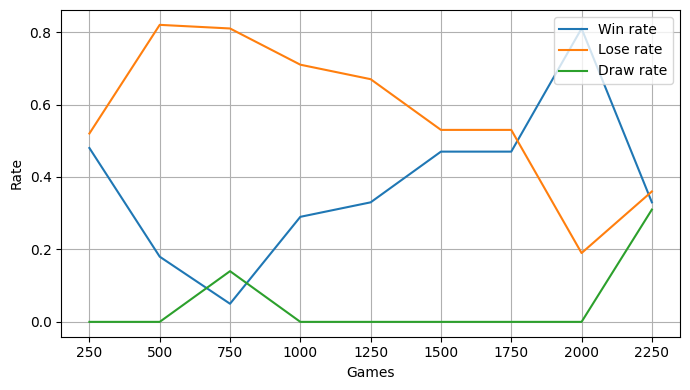

Weights: [0.01703241318442017, 0.6557556411685606, 0.2634425661777641, 0.923892529777435, -0.09621335635431646, 0.16982568856943372]


In [8]:
best_params = optuna.load_study(study_name="a", storage=f"sqlite:///{db_path}").best_params
print(best_params)

V, best_win_rate, train_history = train(trial=None, num_games=best_params['num_games'], alpha=best_params['alpha'], eps=best_params['eps'], Vs=Vs, seed=42)
plot_train_history(train_history)
print(f"Weights: {V.w}")

# 重みの保存
weights_path = os.path.join(MODEL_SAVE_DIR, "5.json")
with open(weights_path, "w") as f:
    json.dump(V.w, f)

In [9]:
def print_board(game: Othello):
    """
    盤面を表示する。
    """
    b = game.board
    header = "   " + " ".join([chr(ord('a')+c) for c in range(8)])
    print(header)
    for r in range(8):
        line = f"{r+1:2d} "
        for c in range(8):
            if b[r][c] == BLACK: ch = "○"
            elif b[r][c] == WHITE: ch = "●"
            else: ch = "."
            line += ch + " "
        print(line)
    turn = "Black(○)" if game.player == BLACK else "White(●)"
    print(f"Turn: {turn}")

def parse_move(s: str):
    """
    s: "a1", "pass", "p"
    """
    s = s.strip().lower()
    if s in ("pass", "p"): return None
    if len(s) != 2: return "ERR"
    col = ord(s[0]) - ord('a')
    row = ord(s[1]) - ord('1')
    if 0 <= row < 8 and 0 <= col < 8:
        return (row, col)
    return "ERR"

def human_vs_agent(V: LinearValue, human_color=BLACK, seed=123, use_search=True, search_depth=2):
    random.seed(seed)
    g = Othello()
    tt = TranspositionTable(capacity=300_000)
    while not g.terminal():
        print_board(g)
        p = g.player
        if p == human_color:
            moves = g.legal_moves(p)
            if not moves:
                print("No legal moves. Pass.")
                g.player = opponent(g.player)
                continue
            # 参考: 合法手の表示
            print("Legal moves:", " ".join(f"{chr(ord('a')+c)}{r+1}" for r,c in moves))
            s = input("Your move (e.g., d3 / pass / quit): ").strip().lower()
            if s in ("quit", "q"):
                print("Quit.")
                return
            if s in ("pass", "p"):
                print("You have legal moves; pass is not allowed. Try again.")
                continue
            mv = parse_move(s)
            if mv == "ERR":
                print("Format error. Try again.")
                continue
            if mv not in moves:
                print("Illegal. Try again.")
                continue
            g.play(mv[0], mv[1], p)
        else:
            # エージェント手：探索 or 貪欲
            if use_search:
                m = choose_move_search(g, p, V, depth=search_depth, tt=tt)
            else:
                m = choose_move(g, p, opp_type="greedy", V=V)
            if m is None:
                print("(Agent) Pass.")
                g.player = opponent(g.player)
                continue
            print(f"(Agent) move: {chr(ord('a')+m[1])}{m[0]+1}")
            g.play(m[0], m[1], p)

    print_board(g)
    w = g.winner()
    if w == 0:
        print("Draw!")
    elif w == BLACK:
        print("Black(○) wins!")
    else:
        print("White(●) wins!")

In [ ]:
# 重みのロード
V = LinearValue(n_feat=len(features(Othello(), BLACK)))
with open(weights_path, 'r') as f:
    V.w = json.load(f)

# 人間が白（⚫︎）、エージェントが黒（○）
human_vs_agent(V, human_color=WHITE, seed=2025, search_depth=3)

   a b c d e f g h
 1 . . . . . . . . 
 2 . . . . . . . . 
 3 . . . . . . . . 
 4 . . . ● ○ . . . 
 5 . . . ○ ● . . . 
 6 . . . . . . . . 
 7 . . . . . . . . 
 8 . . . . . . . . 
Turn: Black(○)
(Agent) move: d3
   a b c d e f g h
 1 . . . . . . . . 
 2 . . . . . . . . 
 3 . . . ○ . . . . 
 4 . . . ○ ○ . . . 
 5 . . . ○ ● . . . 
 6 . . . . . . . . 
 7 . . . . . . . . 
 8 . . . . . . . . 
Turn: White(●)
Legal moves: c3 e3 c5
   a b c d e f g h
 1 . . . . . . . . 
 2 . . . . . . . . 
 3 . . . ○ ● . . . 
 4 . . . ○ ● . . . 
 5 . . . ○ ● . . . 
 6 . . . . . . . . 
 7 . . . . . . . . 
 8 . . . . . . . . 
Turn: Black(○)
(Agent) move: f4
   a b c d e f g h
 1 . . . . . . . . 
 2 . . . . . . . . 
 3 . . . ○ ● . . . 
 4 . . . ○ ○ ○ . . 
 5 . . . ○ ● . . . 
 6 . . . . . . . . 
 7 . . . . . . . . 
 8 . . . . . . . . 
Turn: White(●)
Legal moves: c3 g3 c5 g5
   a b c d e f g h
 1 . . . . . . . . 
 2 . . . . . . . . 
 3 . . . ○ ● . . . 
 4 . . . ○ ○ ● . . 
 5 . . . ○ ● . ● . 
 6 . . . . . . . . 
 7 .